In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os

import numpy as np
import pandas as pd
import scipy.linalg as LA
import scipy.sparse as sps
from scipy.io import loadmat

import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

from utils import (fcps_reader, FCPSDataset, ImageMatDataset,
                   AutoEncoder, LLE, SparseLLE, Trainer, LambdaScheduler)

# Dimensionality Reduction
from sklearn.decomposition import PCA
from sklearn.manifold import LocallyLinearEmbedding, MDS, Isomap

from umap import UMAP

from scipy.spatial.distance import pdist, squareform
from sklearn.neighbors import NearestNeighbors

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

from tqdm import tqdm

# animation
from matplotlib import animation
from celluloid import Camera

# model io
import joblib

# visualisation of the weights matrix
import r1svd

from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score as NMI
from scipy.spatial.distance import pdist
from sklearn.neighbors import NearestNeighbors

# %matplotlib notebook

In [3]:
def anim_to_html(anim):
    plt.close(anim._fig)
    return anim.to_html5_video()

animation.Animation._repr_html_ = anim_to_html

cmap = plt.cm.Spectral

## Reading the datasets

In [4]:
fcps_datasets = ['Atom', 'Chainlink', 'GolfBall', 'Hepta', 'Tetra']

Text(0.5, 0.92, "'Atom' dataset")

Text(0.5, 0.92, "'Chainlink' dataset")

Text(0.5, 0.92, "'GolfBall' dataset")

Text(0.5, 0.92, "'Hepta' dataset")

Text(0.5, 0.92, "'Tetra' dataset")

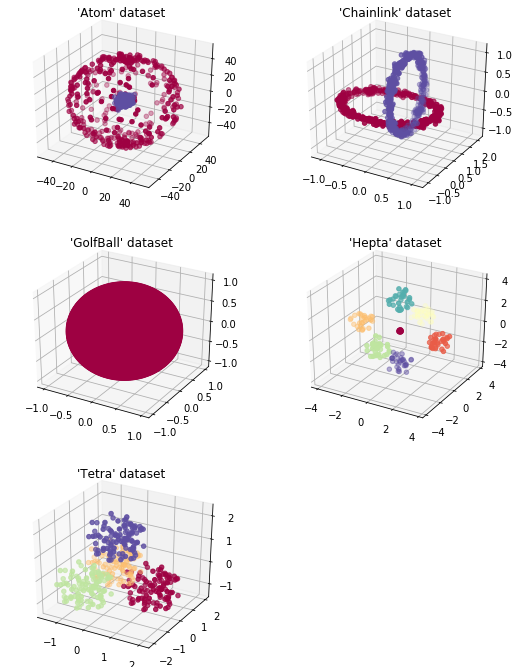

In [5]:
fig = plt.figure(figsize=(9,12))
for i, name in enumerate(fcps_datasets):
    data = fcps_reader(name)
    ax = fig.add_subplot(3,2,i+1, projection='3d')
    ax.scatter(data.x1, data.x2, data.x3, c=data.y, cmap=cmap)
    ax.set_title(f"{name!r} dataset")

In [6]:
data = fcps_reader('Hepta')
data.head()

,x1,x2,x3,y
0,,,,
1,-0.063274,0.027734,0.022683,1
2,-0.000731,0.048211,0.069198,1
3,-0.060767,-0.009080,0.053085,1
4,0.013252,-0.011876,0.055324,1
5,-0.054508,-0.003813,0.001738,1


In [7]:
data.y.value_counts().sort_index()

1    32
2    30
3    30
4    30
5    30
6    30
7    30
Name: y, dtype: int64

In [8]:
X = data.iloc[:, :-1].values
y = data.y

In [9]:
n_neighbors=9

## Dimensionality reduction methods

In [10]:
%%time
pca_embed = PCA(n_components=2).fit_transform(X)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.58 ms


In [11]:
%%time
lle_embed = LocallyLinearEmbedding(n_components=2, n_neighbors=n_neighbors).fit_transform(X)

CPU times: user 15.6 ms, sys: 0 ns, total: 15.6 ms
Wall time: 23.4 ms


In [12]:
%%time
isomap_embed = Isomap(n_components=2, n_neighbors=n_neighbors).fit_transform(X)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 47.8 ms


In [13]:
%%time
mds_embed = MDS(n_components=2).fit_transform(X)

CPU times: user 266 ms, sys: 15.6 ms, total: 281 ms
Wall time: 258 ms


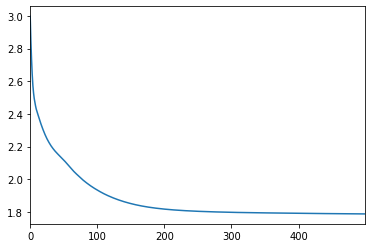

In [14]:
num_epochs = 500

ae = AutoEncoder([3,3,2])

inputs = torch.tensor(X, dtype=torch.float)
def train_ae(ae, inputs, num_epochs=50):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(ae.parameters(), lr=.01, weight_decay=1e-5)
    
    losses = []
    for epoch in range(num_epochs):
        # ===================forward=====================
        enc, dec = ae(inputs)
        loss = criterion(dec, inputs)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
    
    return losses

losses = train_ae(ae, inputs, num_epochs)
pd.Series(losses).plot()

In [15]:
with torch.no_grad():
    ae_embed = ae.encode(inputs).numpy()

### Plotting the results of the dimensionality reduction methods

Text(0.5, 1.0, 'PCA')

Text(0.5, 1.0, 'LLE')

Text(0.5, 1.0, 'ISOMAP')

Text(0.5, 1.0, 'MDS')

Text(0.5, 1.0, 'AutoEncoder')

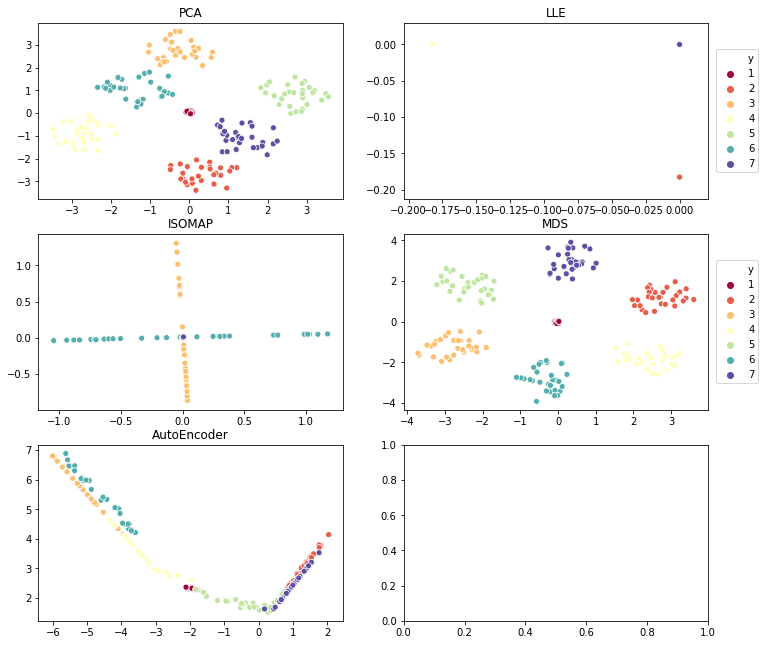

In [16]:
dimred = [("PCA", pca_embed), ("LLE", lle_embed), ("ISOMAP", isomap_embed),
          ("MDS", mds_embed), ("AutoEncoder", ae_embed)]
ncol = 2
fig, axs = plt.subplots(3, ncol, figsize=(12,11))

for i, (ax, (redname, redvals)) in enumerate(zip(axs.flat, dimred), start=1):
    sns.scatterplot(redvals[:, 0], redvals[:, 1], hue=y, ax=ax, palette=cmap, legend='full' if i%ncol==0 else None)
    ax.set_title(redname)
    if i%ncol==0:
        ax.legend(loc='center left', bbox_to_anchor=(1.01,.5))

### LLE implementation

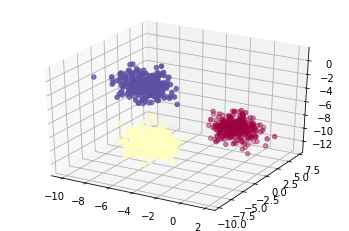

In [17]:
from sklearn.datasets import make_blobs
X_t, y_t = make_blobs(n_samples=900, n_features=3, centers=3, random_state=1)

ax = plt.axes(projection='3d')

ax.scatter(X_t[:,0], X_t[:,1], X_t[:,2], c=y_t, cmap=cmap)

In [18]:
n_neigh = 31

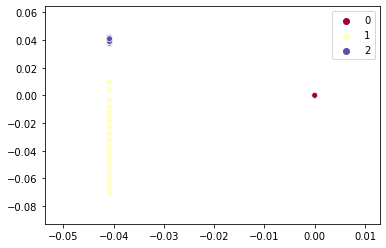

In [19]:
# %%timeit 
lleX = LocallyLinearEmbedding(n_neighbors=n_neigh).fit_transform(X_t)
sns.scatterplot(lleX[:,0], lleX[:,1],hue=y_t, palette=cmap)

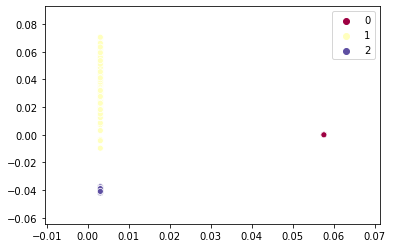

In [20]:
S, mylleX = LLE(n_neighbors=n_neigh).fit_transform(X_t)
sns.scatterplot(mylleX[:,0], mylleX[:,1],hue=y_t, palette=cmap)

In [21]:
# S, splleX = SparseLLE(n_neighbors=n_neigh).fit_transform(X_t)
# sns.scatterplot(splleX[:,0], splleX[:,1],hue=y_t, palette=cmap)

In [22]:
# # calculate the embeddings
#         # u, w, v = sps.linalg.svds(W, k=n-1, which='LM')
#         w, v = sps.linalg.eigsh(M, self.d+1, sigma=0.0)
#     #     u, w, v = LA.svd(W.toarray())
#     #     w, v = sps.linalg.eigsh(W.T @ W, k=d+1, which='SM', sigma=0)
#     #     print(w.shape, v.shape)
#     #     v = v.T

#         idx = np.argsort(w)[1:self.d]
#         Y = v.T[:, idx]  # * n**.5

In [23]:
def loss(X, encoded, decoded, S, l):
    """Computes the autoencoder loss
    loss = ||X - decoded||^2 + l * ||encoded - S*encoded||^2
    the autoencoder should keep as much information while also
    keeping the neighborhoods as separate as possible // could be better phrased
    """
    sim = X - decoded  # how similar the result is to the input
    if l == 0:
        return (sim ** 2).sum()

    sep = encoded - S @ encoded  # how well separated the embedding is
    return (sim ** 2).sum() + l * (sep ** 2).sum()

In [24]:
fcps_datasets

['Atom', 'Chainlink', 'GolfBall', 'Hepta', 'Tetra']

In [25]:
# %%prun -s time -l 20
# train = fcps_reader(fcps_datasets[-2])
# X_train = train.iloc[:, :-1].values
# y_train = train.y.values

X_train = X_t
y_train = y_t 

# mat = loadmat('../input/COIL20.mat')
# X_train = mat['fea']
# y_train = mat['gnd'].ravel()

# idx = np.arange(y_train.shape[0])
# np.random.shuffle(idx)
# X_train = X_train[idx, :]
# y_train = y_train[idx]

n_neigh = 20
inputs = torch.tensor(X_train, dtype=torch.float)
num_epochs = 100

In [26]:
# print(X_train.shape, y_train.shape)

ae = AutoEncoder([3,3,2])
# ae = AutoEncoder([1024, 256, 64, 16, 2])

optimizer = torch.optim.Adam(ae.parameters(), lr=.001, weight_decay=0) #1e-5)

losses = []
fig, ax = plt.subplots()
camera = Camera(fig)
r = r1svd.RankOneSvd()
for epoch in tqdm(range(num_epochs)):
    # encode
    enc, dec = ae(inputs)
    # compute
    X_enc = enc.detach().numpy()
    S, _ = LLE(n_neigh, X_enc.shape[1]).fit_transform(X_enc)
    
#     ax.spy(r.fit_transform(np.abs(S)))
#     ax.spy(np.abs(S))
    sns.scatterplot(X_enc[:,0], X_enc[:,1],hue=y_train, palette=cmap, ax=ax, legend=False)
    camera.snap()
    
    cost = loss(inputs, enc, dec, torch.tensor(S, dtype=torch.float),
                l=.5 if epoch <= 5 else 0.5 + .1*(epoch - num_epochs))

    losses.append(cost.item())
    
    # update autoencoder weights
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

plt.close(fig)
# losses = train_ae(ae, inputs, 50)

  0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 1/100 [00:00<00:18,  5.47it/s]

  2%|▏         | 2/100 [00:00<00:18,  5.39it/s]

  3%|▎         | 3/100 [00:00<00:18,  5.35it/s]

  4%|▍         | 4/100 [00:00<00:18,  5.31it/s]

  5%|▌         | 5/100 [00:00<00:18,  5.14it/s]

  6%|▌         | 6/100 [00:01<00:18,  5.01it/s]

  7%|▋         | 7/100 [00:01<00:18,  5.08it/s]

  8%|▊         | 8/100 [00:01<00:18,  5.07it/s]

  9%|▉         | 9/100 [00:01<00:18,  5.04it/s]

 10%|█         | 10/100 [00:02<00:18,  4.78it/s]

 11%|█         | 11/100 [00:02<00:18,  4.88it/s]

 12%|█▏        | 12/100 [00:02<00:17,  4.97it/s]

 13%|█▎        | 13/100 [00:02<00:17,  5.05it/s]

 14%|█▍        | 14/100 [00:02<00:16,  5.06it/s]

 15%|█▌        | 15/100 [00:02<00:16,  5.09it/s]

 16%|█▌        | 16/100 [00:03<00:16,  5.14it/s]

 17%|█▋        | 17/100 [00:03<00:16,  5.15it/s]

 18%|█▊        | 18/100 [00:03<00:16,  5.08it/s]

 19%|█▉        | 19/100 [00:03<00:15,  5.14it/s]

 20%|██        | 20/100 [00:03<00:15,  5.19it/s]

 21%|██        | 21/100 [00:04<00:15,  5.17it/s]

 22%|██▏       | 22/100 [00:04<00:15,  5.16it/s]

 23%|██▎       | 23/100 [00:04<00:15,  5.12it/s]

 24%|██▍       | 24/100 [00:04<00:14,  5.17it/s]

 25%|██▌       | 25/100 [00:04<00:14,  5.20it/s]

 26%|██▌       | 26/100 [00:05<00:14,  5.16it/s]

 27%|██▋       | 27/100 [00:05<00:14,  5.17it/s]

 28%|██▊       | 28/100 [00:05<00:13,  5.21it/s]

 29%|██▉       | 29/100 [00:05<00:13,  5.13it/s]

 30%|███       | 30/100 [00:05<00:13,  5.11it/s]

 31%|███       | 31/100 [00:06<00:13,  5.11it/s]

 32%|███▏      | 32/100 [00:06<00:13,  5.14it/s]

 33%|███▎      | 33/100 [00:06<00:13,  5.13it/s]

 34%|███▍      | 34/100 [00:06<00:12,  5.09it/s]

 35%|███▌      | 35/100 [00:06<00:14,  4.46it/s]

 36%|███▌      | 36/100 [00:07<00:13,  4.79it/s]

 37%|███▋      | 37/100 [00:07<00:12,  4.87it/s]

 38%|███▊      | 38/100 [00:07<00:12,  4.94it/s]

 39%|███▉      | 39/100 [00:07<00:12,  5.01it/s]

 40%|████      | 40/100 [00:07<00:11,  5.04it/s]

 41%|████      | 41/100 [00:08<00:11,  5.06it/s]

 42%|████▏     | 42/100 [00:08<00:11,  5.12it/s]

 43%|████▎     | 43/100 [00:08<00:11,  5.13it/s]

 44%|████▍     | 44/100 [00:08<00:10,  5.14it/s]

 45%|████▌     | 45/100 [00:08<00:10,  5.13it/s]

 46%|████▌     | 46/100 [00:09<00:10,  5.08it/s]

 47%|████▋     | 47/100 [00:09<00:10,  4.99it/s]

 48%|████▊     | 48/100 [00:09<00:10,  4.87it/s]

 49%|████▉     | 49/100 [00:09<00:10,  4.82it/s]

 50%|█████     | 50/100 [00:09<00:10,  4.83it/s]

 51%|█████     | 51/100 [00:10<00:09,  4.91it/s]

 52%|█████▏    | 52/100 [00:10<00:09,  4.98it/s]

 53%|█████▎    | 53/100 [00:10<00:09,  5.03it/s]

 54%|█████▍    | 54/100 [00:10<00:09,  4.95it/s]

 55%|█████▌    | 55/100 [00:10<00:09,  4.99it/s]

 56%|█████▌    | 56/100 [00:11<00:08,  5.02it/s]

 57%|█████▋    | 57/100 [00:11<00:08,  5.08it/s]

 58%|█████▊    | 58/100 [00:11<00:08,  5.08it/s]

 59%|█████▉    | 59/100 [00:11<00:07,  5.13it/s]

 60%|██████    | 60/100 [00:11<00:07,  5.16it/s]

 61%|██████    | 61/100 [00:12<00:07,  5.12it/s]

 62%|██████▏   | 62/100 [00:12<00:07,  5.14it/s]

 63%|██████▎   | 63/100 [00:12<00:07,  5.15it/s]

 64%|██████▍   | 64/100 [00:12<00:07,  5.12it/s]

 65%|██████▌   | 65/100 [00:12<00:06,  5.10it/s]

 66%|██████▌   | 66/100 [00:13<00:06,  5.09it/s]

 67%|██████▋   | 67/100 [00:13<00:06,  5.12it/s]

 68%|██████▊   | 68/100 [00:13<00:06,  5.17it/s]

 69%|██████▉   | 69/100 [00:13<00:06,  5.14it/s]

 70%|███████   | 70/100 [00:13<00:05,  5.18it/s]

 71%|███████   | 71/100 [00:14<00:05,  5.18it/s]

 72%|███████▏  | 72/100 [00:14<00:05,  5.20it/s]

 73%|███████▎  | 73/100 [00:14<00:05,  5.18it/s]

 74%|███████▍  | 74/100 [00:14<00:05,  5.14it/s]

 75%|███████▌  | 75/100 [00:14<00:04,  5.16it/s]

 76%|███████▌  | 76/100 [00:14<00:04,  5.19it/s]

 77%|███████▋  | 77/100 [00:15<00:04,  5.09it/s]

 78%|███████▊  | 78/100 [00:15<00:04,  5.13it/s]

 79%|███████▉  | 79/100 [00:15<00:04,  5.10it/s]

 80%|████████  | 80/100 [00:15<00:03,  5.13it/s]

 81%|████████  | 81/100 [00:15<00:03,  5.14it/s]

 82%|████████▏ | 82/100 [00:16<00:03,  5.14it/s]

 83%|████████▎ | 83/100 [00:16<00:03,  5.05it/s]

 84%|████████▍ | 84/100 [00:16<00:03,  5.07it/s]

 85%|████████▌ | 85/100 [00:16<00:02,  5.12it/s]

 86%|████████▌ | 86/100 [00:16<00:02,  5.15it/s]

 87%|████████▋ | 87/100 [00:17<00:02,  5.18it/s]

 88%|████████▊ | 88/100 [00:17<00:02,  5.18it/s]

 89%|████████▉ | 89/100 [00:17<00:02,  5.16it/s]

 90%|█████████ | 90/100 [00:17<00:01,  5.17it/s]

 91%|█████████ | 91/100 [00:17<00:01,  4.80it/s]

 92%|█████████▏| 92/100 [00:18<00:01,  4.59it/s]

 93%|█████████▎| 93/100 [00:18<00:01,  4.73it/s]

 94%|█████████▍| 94/100 [00:18<00:01,  4.59it/s]

 95%|█████████▌| 95/100 [00:18<00:01,  4.63it/s]

 96%|█████████▌| 96/100 [00:19<00:00,  4.73it/s]

 97%|█████████▋| 97/100 [00:19<00:00,  4.76it/s]

 98%|█████████▊| 98/100 [00:19<00:00,  4.48it/s]

 99%|█████████▉| 99/100 [00:19<00:00,  4.34it/s]

100%|██████████| 100/100 [00:20<00:00,  5.00it/s]


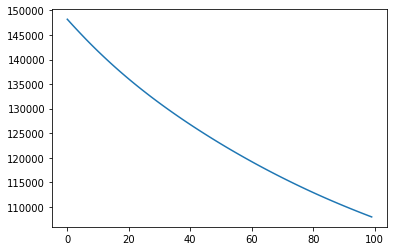

In [27]:
plt.plot(losses)

In [28]:
camera.animate(interval=500)

Text(0.5, 1.0, 'Autoencoder output')

Text(0.5, 1.0, 'LLE (from AE)')

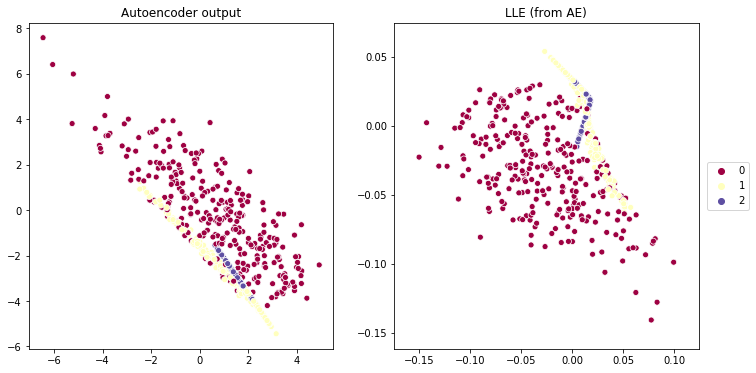

In [29]:
with torch.no_grad():
    ae_lle_embed = ae.encode(inputs).numpy()

fig, axs = plt.subplots(1,2, figsize=(12,6))
sns.scatterplot(ae_lle_embed[:,0], ae_lle_embed[:,1],hue=y_train, palette=cmap, ax=axs[0], legend=False)
axs[0].set_title('Autoencoder output')

_, Y = LLE(n_neigh, ae_lle_embed.shape[1]).fit_transform(ae_lle_embed)
sns.scatterplot(Y[:,0], Y[:,1],hue=y_train, palette=cmap, ax=axs[1], legend='full')
axs[1].set_title('LLE (from AE)')
axs[1].legend(loc='center left', bbox_to_anchor=(1.01,.5))

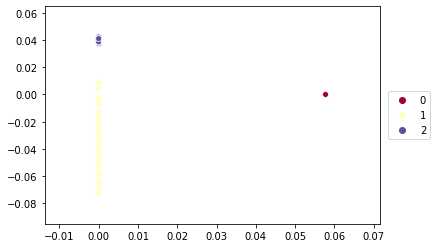

In [30]:
sklle_train = LocallyLinearEmbedding(n_neighbors=n_neigh).fit_transform(X_train)
sns.scatterplot(sklle_train[:,0], sklle_train[:,1],hue=y_train, palette=cmap, legend='full')
plt.legend(loc='center left', bbox_to_anchor=(1.01,.5))

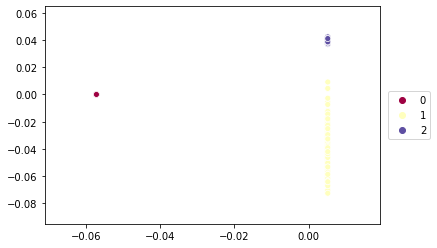

In [31]:
_, lle_train = LLE(n_neighbors=n_neigh).fit_transform(X_train)
sns.scatterplot(lle_train[:,0], lle_train[:,1],hue=y_train, palette=cmap, legend='full')
plt.legend(loc='center left', bbox_to_anchor=(1.01,.5))

In [32]:
# _, splle_train = SparseLLE(n_neighbors=n_neigh).fit_transform(X_train)
# sns.scatterplot(splle_train[:,0], splle_train[:,1],hue=y_train, palette=cmap, legend='full')
# plt.legend(loc='center left', bbox_to_anchor=(1.01,.5))

/mnt/c/python-envs/mlds/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


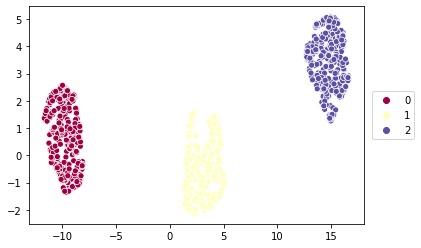

In [33]:
X_umap = UMAP(n_neighbors=n_neigh).fit_transform(X_train)
sns.scatterplot(X_umap[:,0], X_umap[:,1],hue=y_train, palette=cmap, legend='full')
plt.legend(loc='center left', bbox_to_anchor=(1.01,.5))

In [34]:
n_batch=2

In [35]:
atom = FCPSDataset('Atom')
atomloader = DataLoader(atom, batch_size=len(atom)//n_batch,
                        shuffle=True, num_workers=0)

chainlink = FCPSDataset('Chainlink')
chainlinkloader = DataLoader(chainlink, batch_size=len(chainlink)//n_batch,
                        shuffle=True, num_workers=0)

golfball = FCPSDataset('GolfBall')
golfballloader = DataLoader(golfball, batch_size=len(golfball), shuffle=True, num_workers=0)

hepta = FCPSDataset('Hepta')
heptaloader = DataLoader(hepta, batch_size=len(hepta)//n_batch,
                        shuffle=True, num_workers=0)

tetra = FCPSDataset('Tetra')
tetraloader = DataLoader(tetra, batch_size=len(tetra)//n_batch,
                        shuffle=True, num_workers=0)

In [36]:
coil20 = ImageMatDataset('COIL20')
coil20loader = torch.utils.data.DataLoader(coil20, batch_size=len(coil20)//n_batch,
                                          shuffle=True, num_workers=0)

coil100 = ImageMatDataset('COIL100')
coil100loader = torch.utils.data.DataLoader(coil100, batch_size=1000,
                                          shuffle=True, num_workers=0)

mnist = ImageMatDataset('MNIST')
mnistloader = torch.utils.data.DataLoader(mnist, batch_size=1000,
                                          shuffle=True, num_workers=0)

orl = ImageMatDataset('ORL')
orlloader = torch.utils.data.DataLoader(orl, batch_size=len(orl)//n_batch,
                                          shuffle=True, num_workers=0)

usps = ImageMatDataset('USPS')
uspsloader = torch.utils.data.DataLoader(usps, batch_size=1000,
                                          shuffle=True, num_workers=0)

yale = ImageMatDataset('Yale')
yaleloader = torch.utils.data.DataLoader(yale, batch_size=len(yale),
                                          shuffle=True, num_workers=0)

In [37]:
training_params = {
#     'atom': {
#         'dataset': atom,
#         'dataloader': atomloader,
#         'ae_layers': [3,3,2],
#         'd_out': 2,
#         'learning_rate': .1,
#         'n_epochs': 100,
#         'n_neighbors': 20,
#         'lambda_scheduler': LambdaScheduler(lambda_base=.5,lambda_max=5,
#                                             method='sigmoid', c0=2,c1=.8),
#         'lambda_step': 'iter',
#     },
#     'chainlink': {
#         'dataset': chainlink,
#         'dataloader': chainlinkloader,
#         'ae_layers': [3,3,2],
#         'd_out': 2,
#         'learning_rate': .1,
#         'n_epochs': 100,
#         'n_neighbors': 20,
#         'lambda_scheduler': LambdaScheduler(lambda_base=.5,lambda_max=5,
#                                             method='sigmoid',c0=2,c1=.8),
#         'lambda_step': 'iter',
#     },
#     'golfball': {
#         'dataset': golfball,
#         'dataloader': golfballloader,
#         'd_out': 2,
#         'ae_layers': [3,3,2],
#         'learning_rate': .1,
#         'n_epochs': 50,
#         'n_neighbors': 20,
#         'lambda_scheduler': LambdaScheduler(lambda_base=.5,lambda_max=5,
#                                             method='sigmoid',c0=2,c1=.8),
#         'lambda_step': 'iter',
#     },
#     'hepta': {
#         'dataset': hepta,
#         'dataloader': heptaloader,
#         'ae_layers': [3,3,2],
#         'd_out': 2,
#         'learning_rate': .1,
#         'n_epochs': 100,
#         'n_neighbors': 20,
#         'lambda_scheduler': LambdaScheduler(lambda_base=.5,lambda_max=5,
#                                             method='sigmoid',c0=2,c1=.8),
#         'lambda_step': 'iter',
#     },
#     'tetra': {
#         'dataset': tetra,
#         'dataloader': tetraloader,
#         'ae_layers': [3,3,2],
#         'd_out': 2,
#         'learning_rate': .1,
#         'n_epochs': 100,
#         'n_neighbors': 20,
#         'lambda_scheduler': LambdaScheduler(lambda_base=.5,lambda_max=5,
#                                             method='sigmoid',c0=2,c1=.8),
#         'lambda_step': 'iter',
#     },
    # image datasets
    'coil20': {
        'dataset': coil20,
        'dataloader': coil20loader,
        'ae_layers': [1024, 512, 256, 64, 32, 10],
        'd_out': 10,
        'learning_rate': .001,
        'n_epochs': 100,
        'n_neighbors': 50,
        'lambda_scheduler': LambdaScheduler(lambda_base=.5,lambda_max=10,
                                            method='sigmoid',c0=5,c1=.8),
        'lambda_step': 'iter',
    },
    'coil100': {
        'dataset': coil100,
        'dataloader': coil100loader,
        'ae_layers': [1024, 512, 256, 64, 32, 10],
        'd_out': 10,
        'learning_rate': .001,
        'n_epochs': 50,
        'n_neighbors': 50,
        'lambda_scheduler': LambdaScheduler(lambda_base=.5,lambda_max=10,
                                            method='sigmoid',c0=5,c1=.8),
        'lambda_step': 'iter',
    },
    'mnist': {
        'dataset': mnist,
        'dataloader': mnistloader,
        'ae_layers': [784, 512, 256, 64, 32, 10],
        'd_out': 10,
        'learning_rate': .001,
        'n_epochs': 50,
        'sparse_lle': False,
        'predict_lle': True,
        'n_neighbors': 50,
        'lambda_scheduler': LambdaScheduler(lambda_base=.5,lambda_max=10,
                                            method='sigmoid',c0=5,c1=.8),
        'lambda_step': 'iter',
    },
    'orl': {
        'dataset': orl,
        'dataloader': orlloader,
        'ae_layers': [1024,512,64, 32, 10],
        'd_out': 10,
        'learning_rate': .001,
        'n_epochs': 100,
        'n_neighbors': 20,
        'lambda_scheduler': LambdaScheduler(lambda_base=.5,lambda_max=10,
                                            method='sigmoid',c0=5,c1=.8),
        'lambda_step': 'iter',
    },
    'usps': {
        'dataset': usps,
        'dataloader': uspsloader,
        'ae_layers': [256, 128, 64, 32, 10],
        'd_out': 10,
        'learning_rate': .001,
        'n_epochs': 100,
        'n_neighbors': 50,
        'lambda_scheduler': LambdaScheduler(lambda_base=.5,lambda_max=10,
                                            method='sigmoid',c0=5,c1=.8),
        'lambda_step': 'iter',
    },
    'yale': {
        'dataset': yale,
        'dataloader': yaleloader,
        'ae_layers': [1024, 512, 256, 64, 32, 10],
        'd_out': 10,
        'learning_rate': .001,
        'n_epochs': 100,
        'n_neighbors': 20,
        'lambda_scheduler': LambdaScheduler(lambda_base=.5,lambda_max=10,
                                            method='sigmoid',c0=5,c1=.8),
        'lambda_step': 'iter',
    },
}

In [38]:
save_dir = '../models/lle_ae_equal'

In [39]:
# %%prun -s time
def train_model(ae_layers, d_out, dataset, dataloader, name,
                learning_rate=.001, n_epochs=50,
                sparse_lle=False, predict_lle=True, n_neighbors=9,
                lambda_scheduler=None, lambda_step='batch', n_runs=10, random_seeds=None):
    
    if random_seeds == None:
        random_seeds = np.random.randint(100, size=n_runs)
    elif len(random_seeds) != n_runs:
        raise ValueError("Number of random seeds should be the same as the number of runs")
    
    labels = dataset.y.numpy().ravel()
    n_classes = len(np.unique(labels))
    
    best_trainer = None
    best_loss = None
#     trainers = []
    for i, random_seed in zip(range(n_runs), random_seeds):
        net = AutoEncoder(ae_layers)
        optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=1e-5)
    
        torch.manual_seed(random_seed)
        np.random.seed(random_seed)
        
        trainer = Trainer(net, d_out, dataloader, dataset, optimizer,
                          n_epochs=n_epochs, sparse_lle=sparse_lle, n_neighbors=n_neighbors,
                          lambda_scheduler=lambda_scheduler, lambda_step=lambda_step)

        trainer.train_model(track_Y=True)
        loss = trainer.losses[-1]
        print(f"Training #{i+1}/{n_runs}: loss = {loss:7.5f}")
        
        if best_loss is None or loss < best_loss:
            best_loss = loss
            best_trainer = trainer
            
#         trainers.append(trainer)
    
    print(f"Training complete: best loss = {best_loss:7.5f}")
    trainer = best_trainer
    
    joblib.dump(trainer, f"{save_dir}/{name}-model.joblib", compress=3)

    results = trainer.transform(lle=predict_lle)
    net_embed = results['X_ae']
    Y = results['Y']
    
    ncols = 3
    nrows = 2
    fig, axs = plt.subplots(nrows,ncols, figsize=(ncols*5,nrows*6))
    
    n_batch = labels.shape[0] // dataloader.batch_size + (1 if labels.shape[0] % dataloader.batch_size != 0 else 0)
    
    (pd.Series(trainer.losses)
     .rolling(n_batch).mean() # smooth the batch losses
     .plot(ax=axs[0,0]))
    axs[0,0].set_title("Plot of the average loss per batch")
    
    if net_embed.shape[1] == 2:
        sns.scatterplot(net_embed[:,0], net_embed[:,1], hue=labels, palette=cmap, ax=axs[0,1], legend=False)
        axs[0,1].set_title('Autoencoder output')
    else:
        axs[0,1].set_title('LLE (from AE) - not 2D')
    
    if Y is not None:
        sns.scatterplot(Y[:,0], Y[:,1],hue=labels, palette=cmap, ax=axs[0,2], legend='full' if n_classes <= 20 else 'brief')
        axs[0,2].set_title('LLE (from AE)')
        axs[0,2].legend(loc='center left', bbox_to_anchor=(1.01,.5))
    else:
        axs[0,2].set_title('LLE (from AE) - not computed')
        axs[0,1].legend(loc='center left', bbox_to_anchor=(1.01,.5))
    
    X = dataset.X.detach().numpy()
    y = dataset.y.detach().numpy().ravel()
    x_pca = PCA().fit_transform(X)
    sns.scatterplot(x_pca[:,0], x_pca[:,1], hue=labels, palette=cmap, ax=axs[1,0], legend=False)
    axs[1,0].set_title('PCA')
    
    x_umap = UMAP(n_neighbors=n_neighbors).fit_transform(X)
    sns.scatterplot(x_umap[:,0], x_umap[:,1], hue=labels, palette=cmap, ax=axs[1,1], legend=False)
    axs[1,1].set_title('UMAP')
    
    
    if Y is not None:
        _, x_lle = LLE(n_neighbors=n_neighbors).fit_transform(X)
        sns.scatterplot(x_lle[:,0], x_lle[:,1], hue=labels, palette=cmap, ax=axs[1,2], legend='full' if n_classes <= 20 else 'brief')
        axs[1,2].legend(loc='center left', bbox_to_anchor=(1.01,.5))
        axs[1,2].set_title('LLE')
    else:
        axs[0,2].set_title('LLE - not computed')
        x_lle = None
        axs[1,1].legend(loc='center left', bbox_to_anchor=(1.01,.5))
        
    joblib.dump({
        'Y': Y,
        'ae': net_embed,
        'umap': UMAP(n_neighbors=n_neighbors, n_components=d_out).fit_transform(X),
        'pca': PCA(n_components=d_out).fit_transform(X)
        }, f"{save_dir}/{name}-embeddings.joblib", compress=3)

    return fig, trainer, dict(Y=Y, X_ae=net_embed) #{'trainers': trainers}

In [40]:
# %prun -s time fig_atom, trainer_atom, debug_res = train_model(**training_params['atom'])
# fig_atom, trainer_atom, debug_res = train_model(**training_params['atom'])

In [41]:
def plot_all_res(trainers, dataset):
    fig, axs = plt.subplots(2,5,figsize=(5*5,2*6))
    losses_order = np.argsort([tr.losses[-1] for tr in trainers])[::-1]
    for ax,idx in zip(axs.ravel(), losses_order):
        tr = trainers[idx]
        res = tr.transform(lle=True)
        emb = res['Y']
        ax = sns.scatterplot(emb[:,0], emb[:,1],hue=dataset.y.numpy().ravel(), palette=cmap, ax=ax);
        _ = ax.set_title(f"loss = {tr.losses[-1]}");

In [42]:
# plot_all_res(debug_res['trainers'], atom)

In [43]:
# trainer_atom.y_camera_.animate(interval=200)

In [44]:
# fig_chainlink, trainer_chainlink, debug_res = train_model(**training_params['chainlink'])

In [45]:
# plot_all_res(debug_res['trainers'], chainlink)

In [46]:
# trainer_chainlink.y_camera_.animate(interval=200)

In [47]:
# fig_golfball, trainer_golfball = train_model(**training_params['golfball'])

In [48]:
# fig_hepta, trainer_hepta, debug_res = train_model(**training_params['hepta'])

In [49]:
# plot_all_res(debug_res['trainers'], hepta)

In [50]:
# trainer_hepta.y_camera_.animate(interval=200)

In [51]:
# fig_tetra, trainer_tetra, debug_res = train_model(**training_params['tetra'])

In [52]:
# plot_all_res(debug_res['trainers'], tetra)

In [53]:
# trainer_tetra.y_camera_.animate(interval=200)

loss: 2957634304.000:   0%|          | 0/100 [00:00<?, ?it/s]

Training #1/10: loss = 231518608.00000


loss: 3600537344.000:   2%|▏         | 2/100 [00:00<00:07, 13.71it/s]

Training #2/10: loss = 245157536.00000


loss: 9789934592.000:   2%|▏         | 2/100 [00:00<00:06, 16.14it/s]

Training #3/10: loss = 228307136.00000


loss: 2617012736.000:   2%|▏         | 2/100 [00:00<00:06, 14.25it/s]

Training #4/10: loss = 274845024.00000


loss: 5163717120.000:   0%|          | 0/100 [00:00<?, ?it/s]

Training #5/10: loss = 265333808.00000


loss: 4545216000.000:   2%|▏         | 2/100 [00:00<00:06, 14.98it/s]

Training #6/10: loss = 241018864.00000


loss: 8234119168.000:   2%|▏         | 2/100 [00:00<00:06, 15.35it/s]

Training #7/10: loss = 241257552.00000


loss: 3027656192.000:   2%|▏         | 2/100 [00:00<00:06, 15.32it/s]

Training #8/10: loss = 238025552.00000


loss: 3369871360.000:   0%|          | 0/100 [00:00<?, ?it/s]

Training #9/10: loss = 266328144.00000


loss: 317209504.000: 100%|██████████| 100/100 [00:06<00:00, 14.29it/s]


Training #10/10: loss = 317209504.00000
Training complete: best loss = 228307136.00000


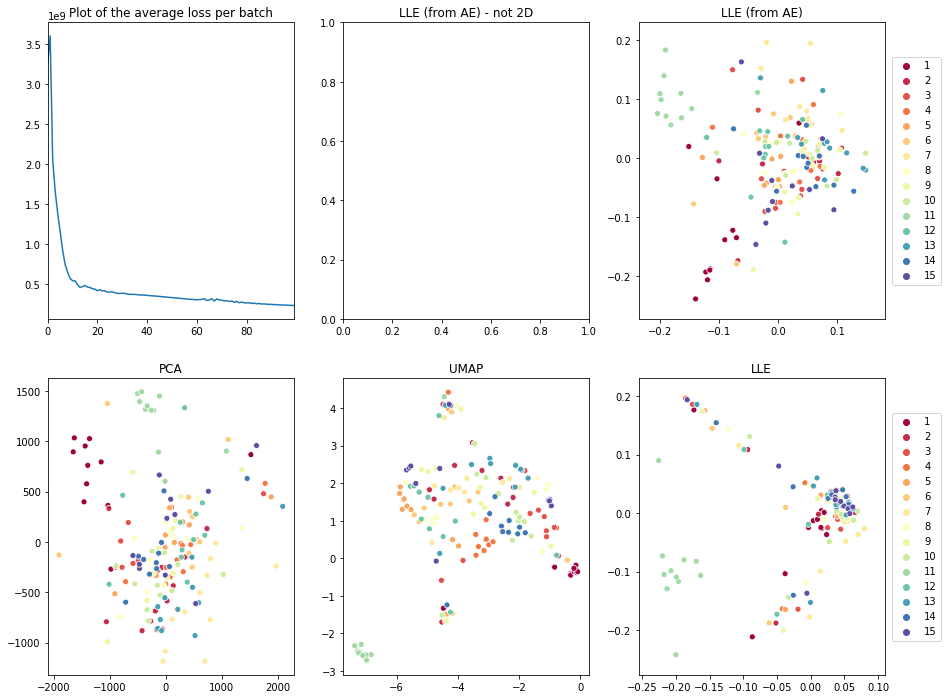

In [54]:
fig_yale, trainer_yale, debug_res = train_model(**training_params['yale'], name='yale')

In [55]:
# trainer_yale.y_camera_.animate(interval=200)

loss: 8210052096.000:   1%|          | 1/100 [00:00<00:12,  7.75it/s]

Training #1/10: loss = 120329184.00000


loss: 23690710272.000:   1%|          | 1/100 [00:00<00:13,  7.39it/s]

Training #2/10: loss = 125502744.00000


loss: 6325517824.000:   1%|          | 1/100 [00:00<00:14,  7.02it/s]

Training #3/10: loss = 125005912.00000


loss: 5875614976.000:   1%|          | 1/100 [00:00<00:13,  7.48it/s]

Training #4/10: loss = 123093920.00000


loss: 5489711104.000:   1%|          | 1/100 [00:00<00:14,  6.87it/s]

Training #5/10: loss = 133837952.00000


  0%|          | 0/100 [00:00<?, ?it/s]

Training #6/10: loss = 127450424.00000


  0%|          | 0/100 [00:00<?, ?it/s]

Training #7/10: loss = 120227680.00000


loss: 11012695808.000:   1%|          | 1/100 [00:00<00:13,  7.19it/s]

Training #8/10: loss = 126330160.00000


  0%|          | 0/100 [00:00<?, ?it/s]

Training #9/10: loss = 118049112.00000


loss: 126519372.000: 100%|██████████| 100/100 [00:15<00:00,  6.48it/s]


Training #10/10: loss = 126650072.00000
Training complete: best loss = 118049112.00000


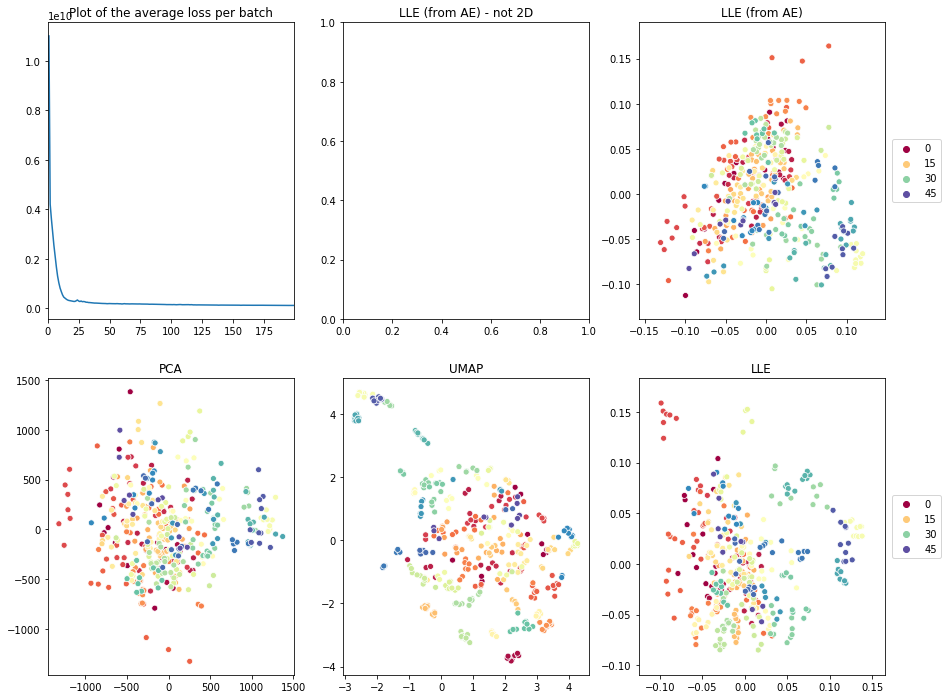

In [56]:
fig_orl, trainer_orl, debug_res = train_model(**training_params['orl'], name='orl')

In [57]:
# trainer_orl.y_camera_.animate(interval=200)

  0%|          | 0/100 [00:00<?, ?it/s]

Training #1/10: loss = 10795.19531


  0%|          | 0/100 [00:00<?, ?it/s]

Training #2/10: loss = 13119.89648


  0%|          | 0/100 [00:00<?, ?it/s]

Training #3/10: loss = 12336.85059


  0%|          | 0/100 [00:00<?, ?it/s]

Training #4/10: loss = 12017.57520


  0%|          | 0/100 [00:00<?, ?it/s]

Training #5/10: loss = 12439.90234


  0%|          | 0/100 [00:00<?, ?it/s]

Training #6/10: loss = 13121.81543


  0%|          | 0/100 [00:00<?, ?it/s]

Training #7/10: loss = 11146.66895


  0%|          | 0/100 [00:00<?, ?it/s]

Training #8/10: loss = 11082.98535


  0%|          | 0/100 [00:00<?, ?it/s]

Training #9/10: loss = 10593.40527


loss: 13507.922: 100%|██████████| 100/100 [01:07<00:00,  1.48it/s]


Training #10/10: loss = 13726.14941
Training complete: best loss = 10593.40527


/mnt/c/python-envs/mlds/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components
/mnt/c/python-envs/mlds/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


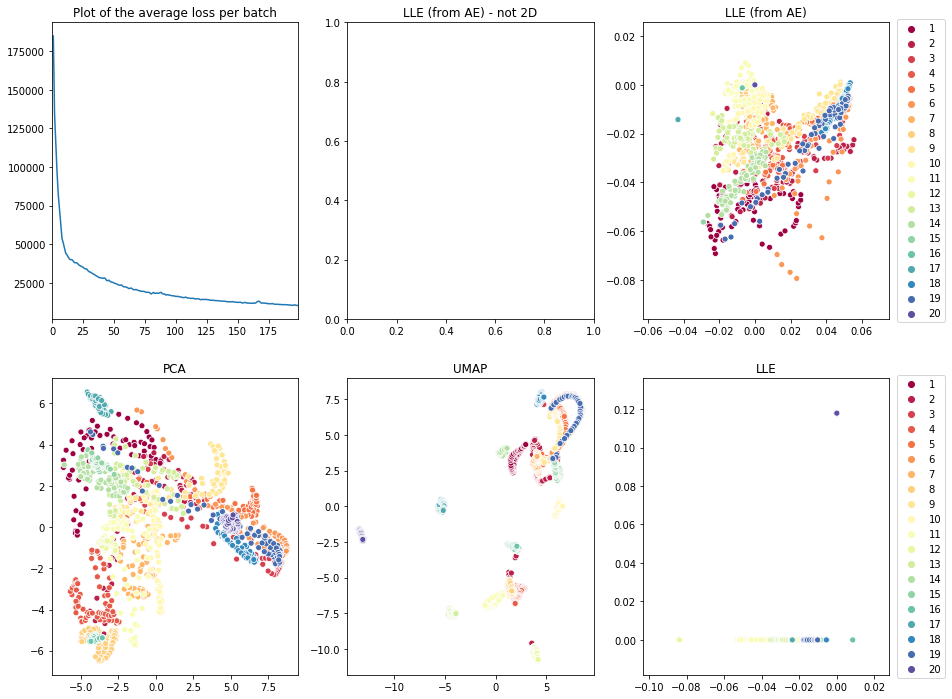

In [58]:
fig_coil20, trainer_coil20, debug_res = train_model(**training_params['coil20'], name='coil20')

In [59]:
# trainer_coil20.y_camera_.animate(interval=200)

  0%|          | 0/50 [00:00<?, ?it/s]

Training #1/10: loss = 143111520.00000


  0%|          | 0/50 [00:00<?, ?it/s]

Training #2/10: loss = 132037488.00000


  0%|          | 0/50 [00:00<?, ?it/s]

Training #3/10: loss = 151376992.00000


  0%|          | 0/50 [00:00<?, ?it/s]

Training #4/10: loss = 163478944.00000


  0%|          | 0/50 [00:00<?, ?it/s]

Training #5/10: loss = 174531088.00000


  0%|          | 0/50 [00:00<?, ?it/s]

Training #6/10: loss = 144111328.00000


  0%|          | 0/50 [00:00<?, ?it/s]

Training #7/10: loss = 141903680.00000


  0%|          | 0/50 [00:00<?, ?it/s]

Training #8/10: loss = 144703584.00000


  0%|          | 0/50 [00:00<?, ?it/s]

Training #9/10: loss = 134338912.00000


loss: 636988930.000: 100%|██████████| 50/50 [02:53<00:00,  3.48s/it] 


Training #10/10: loss = 142039824.00000
Training complete: best loss = 132037488.00000


/mnt/c/python-envs/mlds/lib/python3.7/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../../python-envs/mlds/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/mnt/c/python-envs/mlds/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../../python-e

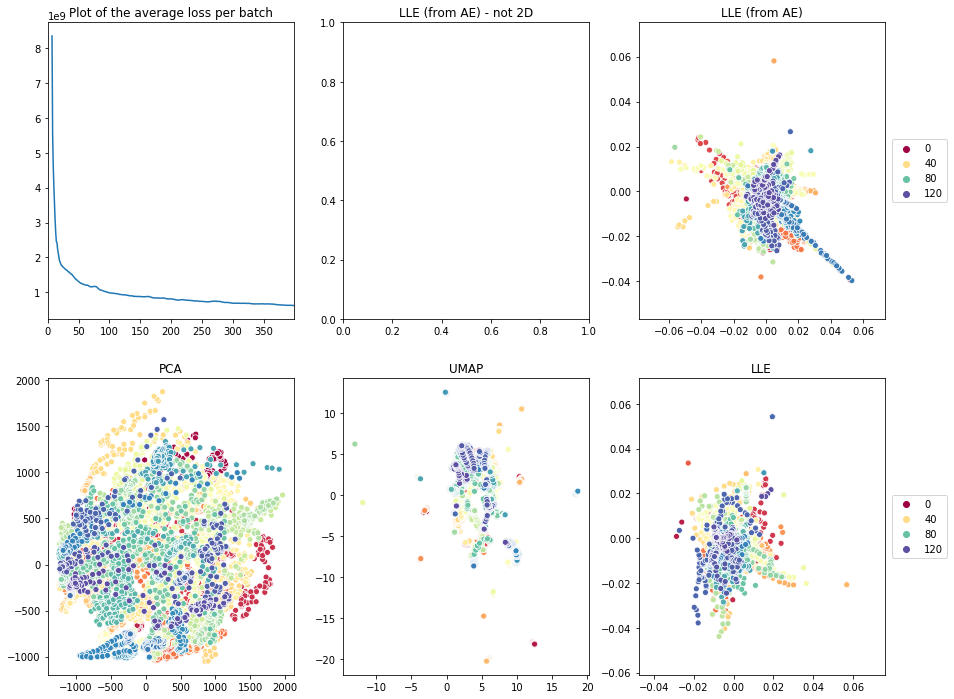

In [60]:
fig_coil100, trainer_coil100, debug_res = train_model(**training_params['coil100'], name='coil100')

In [61]:
# trainer_coil100.y_camera_.animate(interval=200)

  0%|          | 0/100 [00:00<?, ?it/s]

Training #1/10: loss = 4424.50977


  0%|          | 0/100 [00:00<?, ?it/s]

Training #2/10: loss = 4260.35303


  0%|          | 0/100 [00:00<?, ?it/s]

Training #3/10: loss = 3734.03540


  0%|          | 0/100 [00:00<?, ?it/s]

Training #4/10: loss = 4622.95557


  0%|          | 0/100 [00:00<?, ?it/s]

Training #5/10: loss = 4213.29834


  0%|          | 0/100 [00:00<?, ?it/s]

Training #6/10: loss = 4699.59570


  0%|          | 0/100 [00:00<?, ?it/s]

Training #7/10: loss = 4231.00830


  0%|          | 0/100 [00:00<?, ?it/s]

Training #8/10: loss = 4468.67920


  0%|          | 0/100 [00:00<?, ?it/s]

Training #9/10: loss = 4246.56982


loss: 12582.410: 100%|██████████| 100/100 [06:50<00:00,  4.10s/it]


Training #10/10: loss = 3997.62866
Training complete: best loss = 3734.03540


/mnt/c/python-envs/mlds/lib/python3.7/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../../python-envs/mlds/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))
/mnt/c/python-envs/mlds/lib/python3.7/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../../python-envs/mlds/lib/python3.7/site-packages/umap/nndescent.py", l

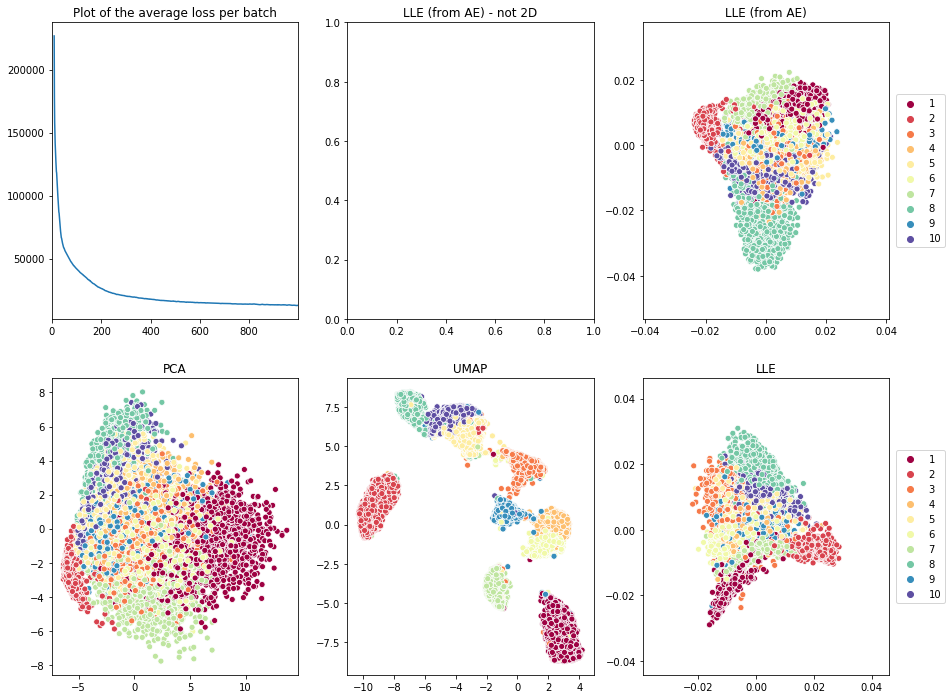

In [62]:
fig_usps, trainer_usps, debug_res = train_model(**training_params['usps'], name='usps')

In [63]:
# trainer_usps.y_camera_.animate(interval=200)

In [ ]:
fig_mnist, trainer_mnist, debug_res = train_model(**training_params['mnist'], name='mnist')

  0%|          | 0/50 [00:00<?, ?it/s]

Training #1/10: loss = 862996544.00000


  0%|          | 0/50 [00:00<?, ?it/s]

Training #2/10: loss = 781521792.00000


  0%|          | 0/50 [00:00<?, ?it/s]

Training #3/10: loss = 846806848.00000


  0%|          | 0/50 [00:00<?, ?it/s]

Training #4/10: loss = 903928832.00000


  0%|          | 0/50 [00:00<?, ?it/s]

Training #5/10: loss = 843602688.00000


  0%|          | 0/50 [00:00<?, ?it/s]

Training #6/10: loss = 941724480.00000


  0%|          | 0/50 [00:00<?, ?it/s]

Training #7/10: loss = 847404992.00000


  0%|          | 0/50 [00:00<?, ?it/s]

Training #8/10: loss = 1023012800.00000


  0%|          | 0/50 [00:00<?, ?it/s]

Training #9/10: loss = 871061120.00000


loss: 971052446.171: 100%|██████████| 50/50 [32:15<00:00, 38.71s/it] 


Training #10/10: loss = 996527488.00000
Training complete: best loss = 781521792.00000
